# Idea
The ideao of the algorithm is to conider the probability distribution of the values linked to $(s,a)$ more than $Q(s,a)$ itself.

To be more precise let's assume $Q(s,a)$ might get values from 0 to 100. We can divide these values in buckets of ten and asking what is the probability of choosing each return bucket.
For example the probabilities might be p=(0, 0.1, 0.2, 0, 0.4, 0, 0.1, 0.1, 0, 0.1).
We can say we are interested in learning the probability distribution p for the given couple (s,a), since we can re-obtain $Q(s,a)$ as 
$$Q(s,a) = \mathbb{E}_p value\_buckets.$$


Distributional DQN is therefore a straight generalization of DQN

## Importing Section

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import math, random
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import clear_output

import gym

from  wrap import make_atari, wrap_deepmind, wrap_pytorch
from collections import deque

## Some Hyper-Parameters 

In [2]:
V_min = -10
V_max = 10
num_atoms = 51
update_plot_every = 10000
update_net_every = 1000

## Device Selection

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device

device(type='cuda', index=0)

## Instatiating environment

In [4]:
env_id = "PongNoFrameskip-v4"
env = make_atari(env_id)
env = wrap_deepmind(env)
env = wrap_pytorch(env)
#env = gym.wrappers.Monitor(env, "./vid" , video_callable=lambda episode_id: (episode_id+1)%10==0, force = True)

## Epsilon-Decay

In [5]:
def epsilon_decay(frame, epsilon_init = 1.0, epsilon_final = 0.1, epsilon_d = 500):
    decay = np.float(frame)/ epsilon_d
    epsilon =  epsilon_final + (epsilon_init - epsilon_final)*math.exp(-1 * decay)
    return epsilon

## Buffer

In [6]:
class Buffer():
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state, is_done):
        # np.expand_dims along axis 0, is
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        self.buffer.append((state, action, reward, next_state, is_done))
        
    def sample(self, batch_size):
        states, actions, rewards, next_states, is_dones = zip(*random.sample(self.buffer, batch_size))
        states = np.concatenate(states)
        next_states = np.concatenate(next_states)
        
        return states, actions, rewards, next_states, is_dones
                                                    
    
    def __len__(self):
        return len(self.buffer)

## Update Function 

Used to learn the new prob distribution. 
Takes agent, buffer and few others inputs to compute the new probability distribution of the state action $(s,a)$ and update the old one.

The computation of the new probability distribution is done via the **projection_distribution** function below.

In [7]:
def update(batch_size, buffer, agent, tg_agent, device):
    # Usato buffer e batch_size
    states, actions, rewards, next_states, is_dones = buffer.sample(batch_size)
    
    states = torch.FloatTensor(np.float32(states)).to(device)
    actions = torch.LongTensor(actions).to(device)
    
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(np.float32(next_states)).to(device)
    is_dones = torch.FloatTensor(np.float32(is_dones)).to(device)
    
    # Next line computes the new probability distribution we should learn (bootstrap)
    # for our states 'states' and actions 'actions' couples
    
    new_dist = projection_distribution(next_states, rewards, is_dones, tg_agent)
    
    actual_dist = agent(states)
    
    # Next 2 lines selct the probability distributions we want to improve using new_dist
    actions = actions.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    actual_dist = actual_dist.gather(1, actions).squeeze(1)
    
    actual_dist.data.clamp_(0.01, 0.99)
    
    # Next line considers categorical cross entropy 
    loss = - (new_dist * actual_dist.log()).sum(1).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

## Projection Distribution function 

In [8]:
def projection_distribution(next_states, rewards, is_dones, tg_agent):
    
    # delta_z is useful in few lines. Skip it for the moment
    delta_z = float(V_max - V_min)/(num_atoms - 1)
    
    # Computing all the possible values (intended as the values a couple (s,a) can receive)
    # Notice they are divided into bukets as the atoms (in a nutshell we do
    # a discretization)
    support = torch.linspace(V_min, V_max, num_atoms).to(device)
    
    # In the next line we compute the next probability distribution and we multiply it
    # elemnt-wise against the values 'support'.
    # Substantially, if the probability dist is [0.2, 0.7, 0.1] and the support is 
    # [2, 3, 4] we get value_dist = [0.2*2, 0.7*3, 0.1*4]
    next_dist = tg_agent(next_states) * support
    
    # In the next line we compute the good old Q(s,a). Simply summing value_dist.
    next_actions = next_dist.sum(2).max(1)[1]
    next_actions = next_actions.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist = next_dist.gather(1, next_actions).squeeze(1)
    
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    is_dones = is_dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1.0 - is_dones) * 0.99 * support
    Tz = Tz.clamp(min = V_min, max = V_max)
    # Next line is used to understand in which value bucket we are. 
    b = (Tz-V_min) / delta_z
    
    # To explain the next lines, let's consider an example. Let's assume the values are ranging in [2, 3, 4]. 
    # Tz = 3.2 and thus (Tz - V_min) is equal to 1.2, with b = 1 (in our example, the atoms are 3).
    # At this point, we would like to take the probability distribution that corresponds to the index 1.2 
    # in array [0.2, 0.7, 0.1] and project it back. This probability is equal to 0.1. But the fact the value 
    # we are considering is not precisely 3 creates some ambiguities in the projection. 3.2 is inside index 2,
    # but closer to index 1 of the array [2, 3, 4]. Shall we project 0.1 back to index 2 or 1? We will thus project 
    # proportionally: we take 1.2-1 = 0.2 and project the20 percent of the probability 0.1 into the bucket 1, and the other 80 % into bucket 2. 
    # This is the content of the next lines.
    
    l = b.floor().long()
    u = b.ceil().long()
    
    # Next line will be clear at the end of the code. 
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long().unsqueeze(1).expand(batch_size, num_atoms).to(device)
    
    # TO-DO Check this better
    proj_dist = torch.zeros(next_dist.size()).to(device)
    proj_dist.view(-1).index_add_(0, (l+offset).view(-1), (next_dist * (u.float() -b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u+offset).view(-1), (next_dist * (b - l.float())).view(-1))
    
    return proj_dist

## Hard_Update

In [9]:
def hard_update(net, tg_net):
    tg_net.load_state_dict(net.state_dict())

## Distributional Model

In [10]:
class DistributionalDQN(nn.Module):
    def __init__(self, observation_space, action_space, num_atoms, V_min, V_max):
        super(DistributionalDQN, self).__init__()
        
        self.observation_space = observation_space # This comes in the shape chanell x height x width)
        self.action_space = action_space
        self.num_atoms = num_atoms
        self.V_min = V_min
        self.V_max = V_max
        
        # Next is the usual feature extractor from images
        self.feat_extractor = nn.Sequential(
            nn.Conv2d(self.observation_space[0], 32, kernel_size = 8, stride = 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1),
            nn.ReLU()
        )
        
        self.linear1 = nn.Linear(self.get_size_images(), 512)
        #self.bn1 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, self.action_space*num_atoms) # Notice, here we have to consider all the possible probablity outcomes per actions (these are the so called atoms)
        
    def get_size_images(self):
        fake_image = torch.ones(self.observation_space).unsqueeze(0)
        size = self.feat_extractor(fake_image).size()
        dimension = np.prod(size)
        return dimension
    
    def forward (self, state):
        batch_size = state.size(0)
        
        state = state / 255.0
        state = self.feat_extractor(state)
        state = state.view(batch_size, -1)
        state = F.relu(self.linear1(state))
        state = F.softmax(self.linear2(state).view(-1, self.num_atoms)) # This is done in a way softmax operates per action in each batch. Which mean softmax is applied to create a probability distribution over the atoms
        state = state.view(-1, self.action_space, self.num_atoms)
        
        return state
    
    def act(self, state, epsilon):
        if random.random() < epsilon:
            action = random.randrange(self.action_space)
            return action
        else:
            state = state.unsqueeze(0)
            prob_dist = self.forward(state).data.cpu() # These are the probability distributions per action
            lin_spaced_values = torch.linspace(self.V_min, self.V_max, self.num_atoms)
            weighted_average_values = prob_dist * lin_spaced_values
            temp = weighted_average_values.sum(2)
            action = temp.max(1)[1].numpy()[0] # The zero at the end is used just to extract the value inside the array. .max consider the maximum along the second axis and then returns where it is located
            return action

## Plotting function

In [11]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## Training

In [12]:
def training(agent, tg_agent, buffer, env, device, num_episodes, batch_size, update_plot_every, update_net_every ):
    losses = []
    episodes_rewards = []
    tot_iterations = 0
    
    for episode in range(1, num_episodes + 1):
        episode_reward = 0
        state = env.reset()
        
        while True:
            # This is more or less like any DQN code
            tot_iterations += 1
            state = torch.FloatTensor(state).to(device)
            epsilon = epsilon_decay(tot_iterations)
            action = agent.act(state, epsilon)
           
            next_state, reward, is_done, _ = env.step(action)
            episode_reward += reward
            state = state.cpu().numpy()
            buffer.push(state, action, reward, next_state, is_done)
            state = next_state
            
            if is_done == True:
                episodes_rewards.append(episode_reward)
                episode_reward = 0
                state = env.reset()
                
            if tot_iterations > 1000:
                loss = update(batch_size, buffer, agent, tg_agent, device)
                losses.append(loss)
                
            if tot_iterations % update_plot_every == 0:
                plot(tot_iterations, episodes_rewards, losses)
            
            if tot_iterations % update_net_every == 0:
                hard_update(agent, tg_agent)

In [13]:
## Instatiating

net = DistributionalDQN(env.observation_space.shape, env.action_space.n, num_atoms, V_min, V_max)

tg_net = DistributionalDQN(env.observation_space.shape, env.action_space.n, num_atoms, V_min, V_max)

net = net.to(device)
tg_net = tg_net.to(device)

optimizer = optim.Adam(net.parameters(), 0.0001)
hard_update(net, tg_net)

num_episodes = 100000
batch_size = 32

buffer = Buffer(1000000)

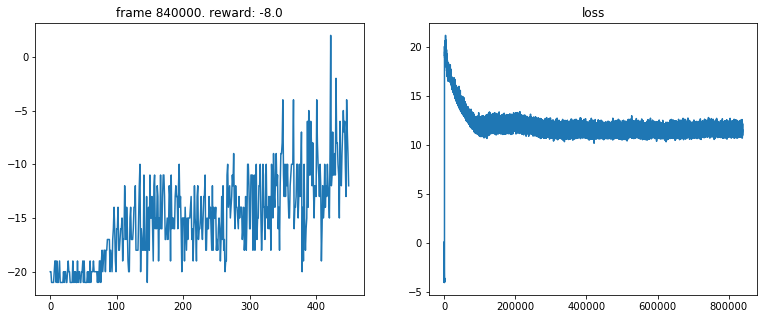

In [ ]:
training(net, tg_net, buffer, env, device, num_episodes, batch_size, update_plot_every, update_net_every )